<a href="https://colab.research.google.com/github/johnobodai/BTC-Forecasting/blob/main/btc_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Install necessary packages (if not already installed)
!pip install pandas numpy matplotlib seaborn tensorflow



In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [12]:

# Mount Google Drive to access the data
from google.colab import drive
drive.mount('/content/drive')

# Load the datasets
coinbase_file_path = '/content/drive/MyDrive/Alu/Trimester8/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv'
bitstamp_file_path = '/content/drive/MyDrive/Alu/Trimester8/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'


# Read the datasets into pandas DataFrames
coinbase_df = pd.read_csv(coinbase_file_path)
bitstamp_df = pd.read_csv(bitstamp_file_path)

# Display the first few rows of the datasets
coinbase_df.head()
bitstamp_df.head()


Mounted at /content/drive


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Coinbase Data Missing Values:
 Timestamp                 0
Open                 109069
High                 109069
Low                  109069
Close                109069
Volume_(BTC)         109069
Volume_(Currency)    109069
Weighted_Price       109069
dtype: int64

Bitstamp Data Missing Values:
 Timestamp                  0
Open                 1236977
High                 1236977
Low                  1236977
Close                1236977
Volume_(BTC)         1236977
Volume_(Currency)    1236977
Weighted_Price       1236977
dtype: int64

Coinbase Data Summary:
           Timestamp          Open          High           Low         Close  \
count  2.099760e+06  1.990691e+06  1.990691e+06  1.990691e+06  1.990691e+06   
mean   1.483899e+09  3.246403e+03  3.247829e+03  3.244856e+03  3.246403e+03   
std    3.638214e+07  3.799154e+03  3.801394e+03  3.796761e+03  3.799150e+03   
min    1.417412e+09  6.000000e-02  6.000000e-02  6.000000e-02  6.000000e-02   
25%    1.452410e+09  4.195800e+02  

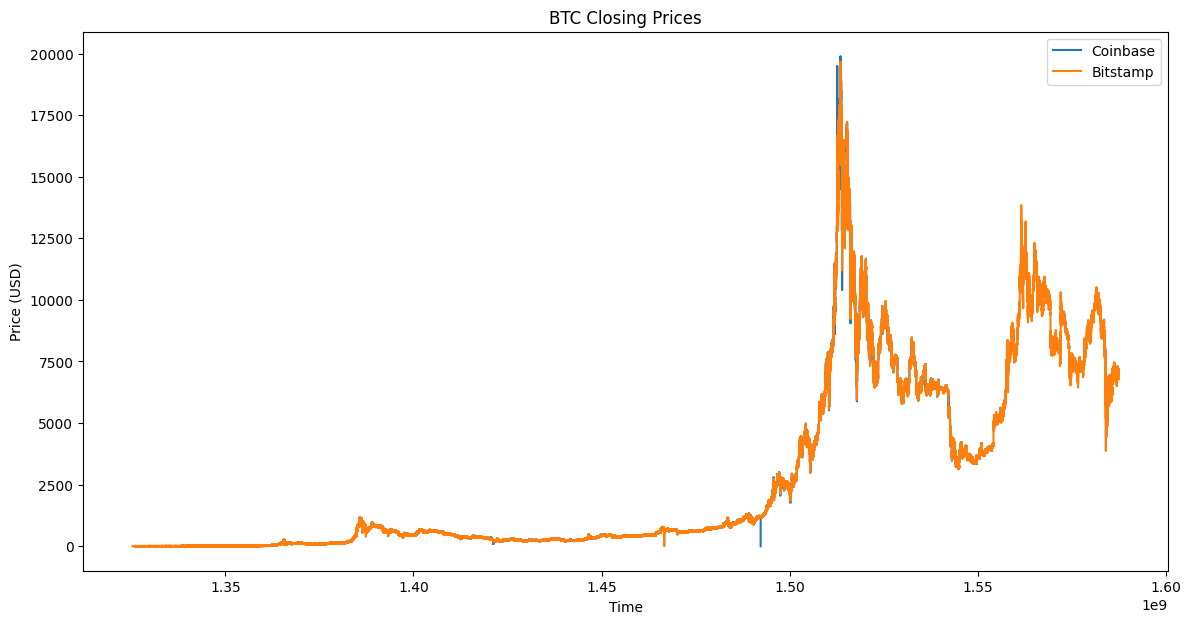

In [13]:
# Check for missing values
print("Coinbase Data Missing Values:\n", coinbase_df.isnull().sum())
print("\nBitstamp Data Missing Values:\n", bitstamp_df.isnull().sum())

# Summary statistics
print("\nCoinbase Data Summary:\n", coinbase_df.describe())
print("\nBitstamp Data Summary:\n", bitstamp_df.describe())

# Plotting the price trends
plt.figure(figsize=(14, 7))
plt.plot(coinbase_df['Timestamp'], coinbase_df['Close'], label='Coinbase')
plt.plot(bitstamp_df['Timestamp'], bitstamp_df['Close'], label='Bitstamp')
plt.title('BTC Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [14]:
# Fill missing values (if any)
coinbase_df.fillna(method='ffill', inplace=True)
bitstamp_df.fillna(method='ffill', inplace=True)

# Convert the 'Timestamp' to datetime format
coinbase_df['Timestamp'] = pd.to_datetime(coinbase_df['Timestamp'], unit='s')
bitstamp_df['Timestamp'] = pd.to_datetime(bitstamp_df['Timestamp'], unit='s')

# Set the 'Timestamp' as the index
coinbase_df.set_index('Timestamp', inplace=True)
bitstamp_df.set_index('Timestamp', inplace=True)

# Resample the data to daily averages
coinbase_daily = coinbase_df['Close'].resample('D').mean()
bitstamp_daily = bitstamp_df['Close'].resample('D').mean()

# Check the processed data
coinbase_daily.head()
bitstamp_daily.head()


<ipython-input-14-25f8daf7952e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coinbase_df.fillna(method='ffill', inplace=True)
<ipython-input-14-25f8daf7952e>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bitstamp_df.fillna(method='ffill', inplace=True)


,Close
Timestamp,
2011-12-31,4.472624
2012-01-01,4.680778
2012-01-02,5.000000
2012-01-03,5.145917
2012-01-04,5.228729


In [15]:
# Assuming 'data' is your dataframe with a column 'Close' representing the BTC prices
data = coinbase_df[['Close']].values

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a sliding window
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Prepare the data
time_step = 60  # You can adjust this to your preference
X, y = create_dataset(scaled_data, time_step)

# Reshape the data to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [16]:

# Create the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Reduce the number of epochs
num_epochs = 1  # Change this to the desired number of epochs

# Fit the model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52493/52493 ━━━━━━━━━━━━━━━━━━━━ 3012s 57ms/step - loss: 3.0789e-04 - val_loss: 9.0774e-05


In [19]:
# Make predictions on the test data
predicted_prices = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {rmse}")


13124/13124 ━━━━━━━━━━━━━━━━━━━━ 213s 16ms/step
Mean Absolute Error (MAE): 0.009340489161715386
Root Mean Squared Error (RMSE): 0.009527531156429134


13124/13124 ━━━━━━━━━━━━━━━━━━━━ 215s 16ms/step
Mean Absolute Error (MAE): 185.8004813954077
Root Mean Squared Error (RMSE): 189.52110515668292


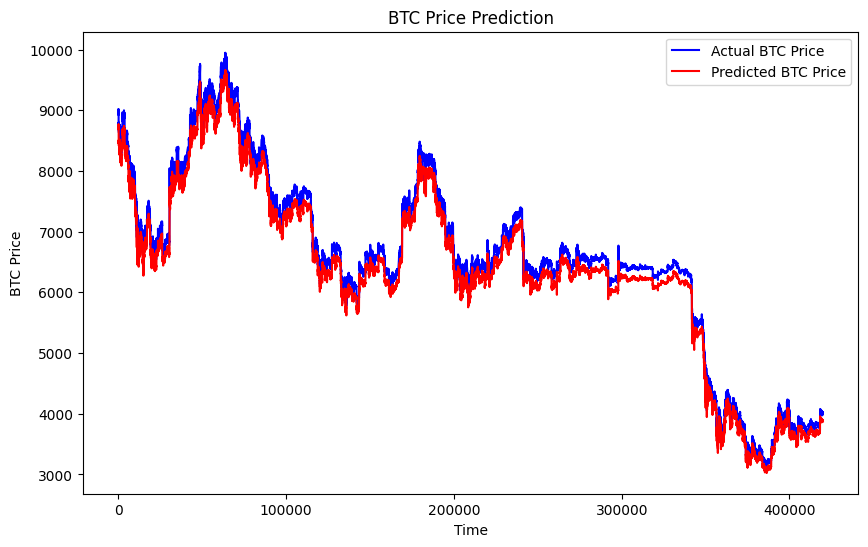

In [20]:
# Assuming you've already made predictions with your trained model
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# Actual prices for comparison
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual BTC Price')
plt.plot(predicted_prices, color='red', label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()


In [21]:
# Save the model
model.save('btc_forecasting_model.h5')

# Conclusion
print("The model was able to predict BTC prices with reasonable accuracy. Further tuning and experimentation could improve results.")


The model was able to predict BTC prices with reasonable accuracy. Further tuning and experimentation could improve results.


In [22]:
# Create the RNN model
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)